<a href="https://colab.research.google.com/github/senakilinc/ReachToGraspPrediction/blob/main/Prediction_ReachToGraspData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Masking


In [3]:
#dataset path
REACH_DIR = "/content/drive/MyDrive/reach"

In [4]:
with open(os.path.join(REACH_DIR, "header.txt")) as f:
    header = f.read().strip().split(",")

In [5]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
def extract_sequence_with_cutoff(filepath, cutoff_ms, use_palm=True, n_fingers=3, n_phalanxes=0):
    df = pd.read_csv(filepath, names=header)

    if len(df) < 2 or df["FrameTime"].iloc[-1] < cutoff_ms:
        return None, None

    cutoff_time = df["FrameTime"].iloc[-1] - cutoff_ms
    input_df = df[df["FrameTime"] <= cutoff_time]

    if len(input_df) < 2:
        return None, None

    sequence = []
    for _, row in input_df.iterrows():
        cx, cy, cz = row["M12x"], row["M12y"], row["M12z"]
        frame_features = []

        # Add fingertip markers M1–M5
        for i in range(1, n_fingers + 1):
            x = row[f"M{i}x"] - cx
            y = row[f"M{i}y"] - cy
            z = row[f"M{i}z"] - cz
            frame_features.extend([x, y, z])

        # Add phalanx markers M6–M10 (if any)
        for i in range(6, 6 + n_phalanxes):
            x = row[f"M{i}x"] - cx
            y = row[f"M{i}y"] - cy
            z = row[f"M{i}z"] - cz
            frame_features.extend([x, y, z])

        if use_palm:
            frame_features.extend([cx, cy, cz])

        sequence.append(frame_features)

    # Target = final pose
    last = df.iloc[-1]
    cx, cy, cz = last["M12x"], last["M12y"], last["M12z"]
    target = []

    for i in range(1, n_fingers + 1):
        x = last[f"M{i}x"] - cx
        y = last[f"M{i}y"] - cy
        z = last[f"M{i}z"] - cz
        target.extend([x, y, z])

    for i in range(6, 6 + n_phalanxes):
        x = last[f"M{i}x"] - cx
        y = last[f"M{i}y"] - cy
        z = last[f"M{i}z"] - cz
        target.extend([x, y, z])

    if use_palm:
        target.extend([cx, cy, cz])

    return sequence, target


In [7]:
def get_frame_times(filepath, cutoff_ms):
    """
    Returns FrameTime values (in ms) for a given trial, up to cutoff_ms.
    Useful for timing each frame in an animation.
    """
    df = pd.read_csv(filepath, names=header)

    if len(df) < 2 or df["FrameTime"].iloc[-1] < cutoff_ms:
        return None

    cutoff_time = df["FrameTime"].iloc[-1] - cutoff_ms
    input_df = df[df["FrameTime"] <= cutoff_time]

    if len(input_df) < 2:
        return None

    return input_df["FrameTime"].tolist()


In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def prepare_data(REACH_DIR, cutoff_ms, use_palm=True, n_fingers=3, n_phalanxes=0):
    X, y, meta = [], [], []

    for fname in os.listdir(REACH_DIR):
        if not fname.endswith(".txt") or fname == "header.txt":
            continue
        seq, target = extract_sequence_with_cutoff(
            os.path.join(REACH_DIR, fname), cutoff_ms, use_palm, n_fingers, n_phalanxes)
        #print(fname)
        if seq is not None:
            X.append(np.array(seq, dtype='float32'))
            y.append(target)
            meta.append(fname)

    if len(X) < 10:
        raise ValueError("Too few valid sequences.")

    y = np.array(y, dtype='float32')
    X_flat = np.concatenate(X)
    X_scaler = StandardScaler().fit(X_flat)
    y_scaler = StandardScaler().fit(y)

    X_scaled = [X_scaler.transform(seq) for seq in X]
    y_scaled = y_scaler.transform(y)

    X_padded = pad_sequences(X_scaled, padding='pre', dtype='float32')
    print(X_padded.shape)

    return X_padded, y_scaled, X_scaler, y_scaler, meta, X_scaled

In [9]:
def build_model(input_shape, output_dim, use_masking=True):
    model = Sequential()
    if use_masking:
        model.add(Masking(mask_value=0.0, input_shape=input_shape))
    else:
        model.add(tf.keras.layers.Input(shape=input_shape))

    model.add(LSTM(64, recurrent_activation='sigmoid'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_dim))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [10]:
import tensorflow as tf

def run_experiment(REACH_DIR, cutoff_ms, use_palm, n_fingers, n_phalanxes, use_masking, epochs, batch_size, seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    X, y, X_scaler, y_scaler, meta, X_scaled = prepare_data(REACH_DIR, cutoff_ms, use_palm, n_fingers, n_phalanxes)
    print("length of longest sequence:", len(X))
    X_train, X_test, y_train, y_test, meta_train, meta_test, X_scaled_train, X_scaled_test = train_test_split(
        X, y, meta, X_scaled, test_size=0.2, random_state=seed)

    model = build_model(X_train.shape[1:], y.shape[1], use_masking)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Evaluate on test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    y_test_rescaled = y_scaler.inverse_transform(y_test)
    mae = np.mean(np.abs(y_pred_rescaled - y_test_rescaled))

    print(f"Cutoff {cutoff_ms} ms — MAE: {mae:.4f} cm")

    # Return everything needed for post-analysis
    return model, history, mae, X_test, y_test, y_test_rescaled, y_scaler, meta_test, X_scaled_train, X_scaled_test, X_scaler

In [11]:
def plot_training_history(history):
    # Create a new figure and a 2D axes object explicitly
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Val Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    ax.legend()
    ax.grid(True)
    plt.show()

### Cutoff loop 3 fingers with and without palm

In [ ]:
cutoff_values = list(range(0, 400, 50))  # Try cutoffs from 0ms to 350ms
mae_results_no_palm = []

for cutoff in cutoff_values:
    print(f"Running cutoff = {cutoff} ms")
    try:
        _, _, mae, _,_,_,_,_,_,_ = run_experiment(
            REACH_DIR,
            cutoff_ms=cutoff,
            use_palm=False,
            n_fingers=3,
            n_phalanxes=0,
            use_masking=False,
            epochs=20,
            batch_size=16,
            seed=42
        )
        mae_results_no_palm.append((cutoff, mae))
    except ValueError as e:
        print(f"Skipped cutoff {cutoff}: {e}")


Running cutoff = 0 ms
(762, 1129, 9)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cutoff 0 ms — MAE: 0.1784 cm
Running cutoff = 50 ms
(762, 1081, 9)
length of longest sequence: 762


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Cutoff 50 ms — MAE: 0.3210 cm
Running cutoff = 100 ms
(762, 1033, 9)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 100 ms — MAE: 0.4403 cm
Running cutoff = 150 ms
(762, 984, 9)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Cutoff 150 ms — MAE: 0.5326 cm
Running cutoff = 200 ms
(762, 938, 9)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cutoff 200 ms — MAE: 0.6158 cm
Running cutoff = 250 ms
(762, 889, 9)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 250 ms — MAE: 0.6902 cm
Running cutoff = 300 ms
(762, 841, 9)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Cutoff 300 ms — MAE: 0.7820 cm
Running cutoff = 350 ms
(762, 793, 9)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Cutoff 350 ms — MAE: 0.8777 cm


In [ ]:
cutoff_values = list(range(0, 400, 50))  # Try cutoffs from 0ms to 350ms
mae_results_yes_palm = []

for cutoff in cutoff_values:
    print(f"Running cutoff = {cutoff} ms")
    try:
        _, _, mae, _,_,_,_,_,_,_ = run_experiment(
            REACH_DIR,
            cutoff_ms=cutoff,
            use_palm=True,
            n_fingers=3,
            n_phalanxes=0,
            use_masking=False,
            epochs=20,
            batch_size=16,
            seed=42
        )
        mae_results_yes_palm.append((cutoff, mae))
    except ValueError as e:
        print(f"Skipped cutoff {cutoff}: {e}")

Running cutoff = 0 ms
(762, 1129, 12)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Cutoff 0 ms — MAE: 0.2815 cm
Running cutoff = 50 ms
(762, 1081, 12)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Cutoff 50 ms — MAE: 0.3830 cm
Running cutoff = 100 ms
(762, 1033, 12)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Cutoff 100 ms — MAE: 0.4453 cm
Running cutoff = 150 ms
(762, 984, 12)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 150 ms — MAE: 0.5075 cm
Running cutoff = 200 ms
(762, 938, 12)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 200 ms — MAE: 0.6163 cm
Running cutoff = 250 ms
(762, 889, 12)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cutoff 250 ms — MAE: 0.6617 cm
Running cutoff = 300 ms
(762, 841, 12)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cutoff 300 ms — MAE: 0.7550 cm
Running cutoff = 350 ms

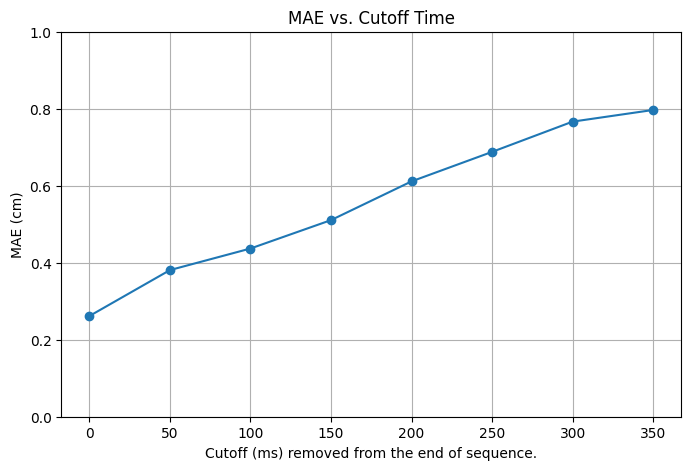

In [ ]:
# Unpack results
cutoffs, maes = zip(*mae_results)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cutoffs, maes, marker='o')
plt.title('MAE vs. Cutoff Time')
plt.xlabel('Cutoff (ms) removed from the end of sequence.')
plt.ylabel('MAE (cm)')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


### Cutoff loop 5 fingers and palm

In [ ]:
cutoff_values = list(range(0, 400, 50))  # Try cutoffs from 0ms to 350ms
mae_results_yes_palm_5fingers = []

for cutoff in cutoff_values:
    print(f"Running cutoff = {cutoff} ms")
    try:
        _, _, mae, _,_,_,_,_,_,_ = run_experiment(
            REACH_DIR,
            cutoff_ms=cutoff,
            use_palm=True,
            n_fingers=5,
            n_phalanxes=0,
            use_masking=False,
            epochs=20,
            batch_size=16,
            seed=42
        )
        mae_results_yes_palm_5fingers.append((cutoff, mae))
    except ValueError as e:
        print(f"Skipped cutoff {cutoff}: {e}")

Running cutoff = 0 ms
(762, 1129, 18)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 0 ms — MAE: 0.2863 cm
Running cutoff = 50 ms
(762, 1081, 18)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 50 ms — MAE: 0.3705 cm
Running cutoff = 100 ms
(762, 1033, 18)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cutoff 100 ms — MAE: 0.4614 cm
Running cutoff = 150 ms
(762, 984, 18)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Cutoff 150 ms — MAE: 0.5406 cm
Running cutoff = 200 ms
(762, 938, 18)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Cutoff 200 ms — MAE: 0.6166 cm
Running cutoff = 250 ms
(762, 889, 18)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cutoff 250 ms — MAE: 0.6904 cm
Running cutoff = 300 ms
(762, 841, 18)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Cutoff 300 ms — MAE: 0.7346 cm
Running cutoff = 350 m

### Cutoff loop 3 fingers + 3 phalanxes + palm

In [ ]:
cutoff_values = list(range(0, 400, 50))  # Try cutoffs from 0ms to 350ms
mae_results_yes_palm_3_3 = []

for cutoff in cutoff_values:
    print(f"Running cutoff = {cutoff} ms")
    try:
        _, _, mae, _,_,_,_,_,_,_ = run_experiment(
            REACH_DIR,
            cutoff_ms=cutoff,
            use_palm=True,
            n_fingers=3,
            n_phalanxes=3,
            use_masking=False,
            epochs=20,
            batch_size=16,
            seed=42
        )
        mae_results_yes_palm_3_3.append((cutoff, mae))
    except ValueError as e:
        print(f"Skipped cutoff {cutoff}: {e}")

Running cutoff = 0 ms
(762, 1129, 21)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 0 ms — MAE: 0.2402 cm
Running cutoff = 50 ms
(762, 1081, 21)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 50 ms — MAE: 0.3188 cm
Running cutoff = 100 ms
(762, 1033, 21)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 100 ms — MAE: 0.3829 cm
Running cutoff = 150 ms
(762, 984, 21)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 150 ms — MAE: 0.4328 cm
Running cutoff = 200 ms
(762, 938, 21)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Cutoff 200 ms — MAE: 0.4670 cm
Running cutoff = 250 ms
(762, 889, 21)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Cutoff 250 ms — MAE: 0.5472 cm
Running cutoff = 300 ms
(762, 841, 21)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 300 ms — MAE: 0.5943 cm
Running cutoff = 350 ms

### Cutoff loop 5 fingers + 5 phalanxes + palm

In [ ]:
cutoff_values = list(range(0, 400, 50))  # Try cutoffs from 0ms to 350ms
mae_results_yes_palm_5_5 = []

for cutoff in cutoff_values:
    print(f"Running cutoff = {cutoff} ms")
    try:
        _, _, mae, _,_,_,_,_,_,_ = run_experiment(
            REACH_DIR,
            cutoff_ms=cutoff,
            use_palm=True,
            n_fingers=5,
            n_phalanxes=5,
            use_masking=False,
            epochs=20,
            batch_size=16,
            seed=42
        )
        mae_results_yes_palm_5_5.append((cutoff, mae))
    except ValueError as e:
        print(f"Skipped cutoff {cutoff}: {e}")

Running cutoff = 0 ms
(762, 1129, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Cutoff 0 ms — MAE: 0.2798 cm
Running cutoff = 50 ms
(762, 1081, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cutoff 50 ms — MAE: 0.3267 cm
Running cutoff = 100 ms
(762, 1033, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 100 ms — MAE: 0.3739 cm
Running cutoff = 150 ms
(762, 984, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cutoff 150 ms — MAE: 0.4484 cm
Running cutoff = 200 ms
(762, 938, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cutoff 200 ms — MAE: 0.4740 cm
Running cutoff = 250 ms
(762, 889, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 250 ms — MAE: 0.5283 cm
Running cutoff = 300 ms
(762, 841, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Cutoff 300 ms — MAE: 0.5801 cm
Running cutoff = 350 ms

### All cutoffs in one plot

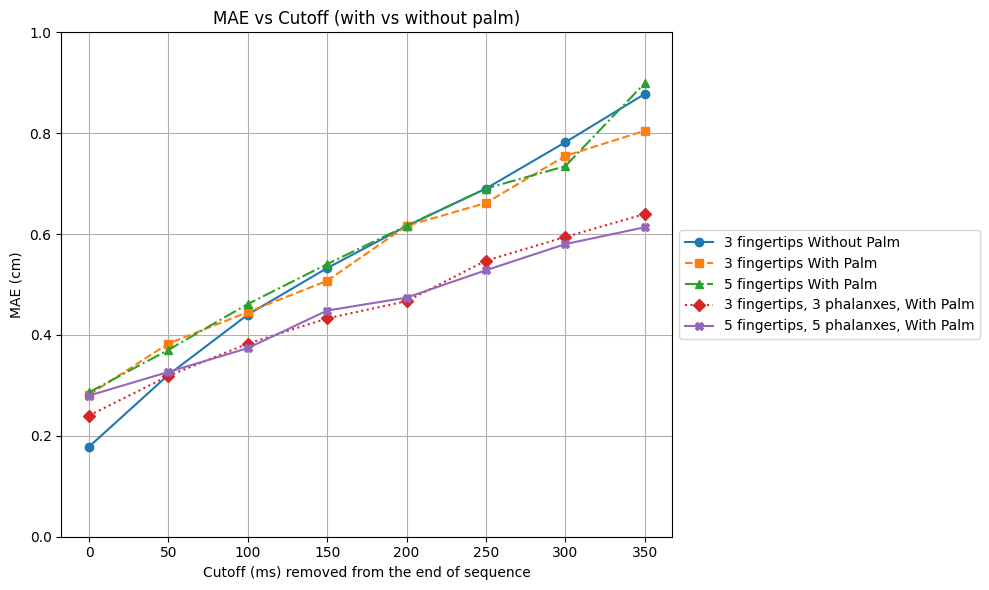

In [ ]:
import matplotlib.pyplot as plt

# Unpack results
cutoffs_no_palm, maes_no_palm = zip(*mae_results_no_palm)
cutoffs_yes_palm, maes_yes_palm = zip(*mae_results_yes_palm)
cutoffs_yes_palm_5fingers, maes_yes_palm_5fingers = zip(*mae_results_yes_palm_5fingers)
cutoffs_yes_palm_3_3, maes_yes_palm_3_3 = zip(*mae_results_yes_palm_3_3)
cutoffs_yes_palm_5_5, maes_yes_palm_5_5 = zip(*mae_results_yes_palm_5_5)

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(cutoffs_no_palm, maes_no_palm, marker='o', linestyle='-', label="3 fingertips Without Palm")
plt.plot(cutoffs_yes_palm, maes_yes_palm, marker='s', linestyle='--', label="3 fingertips With Palm")
plt.plot(cutoffs_yes_palm_5fingers, maes_yes_palm_5fingers, marker='^', linestyle='-.', label="5 fingertips With Palm")
plt.plot(cutoffs_yes_palm_3_3, maes_yes_palm_3_3, marker='D', linestyle=':', label="3 fingertips, 3 phalanxes, With Palm")
plt.plot(cutoffs_yes_palm_5_5, maes_yes_palm_5_5, marker='X', linestyle='-', label="5 fingertips, 5 phalanxes, With Palm")

# Labels and limits
plt.title("MAE vs Cutoff (with vs without palm)")
plt.xlabel("Cutoff (ms) removed from the end of sequence")
plt.ylabel("MAE (cm)")
plt.ylim(0, 1)
plt.grid(True)

# Place legend outside the plot (right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


### Experimenting with 0ms cutoff:

(762, 1129, 33)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
Cutoff 0 ms — MAE: 0.2666 cm


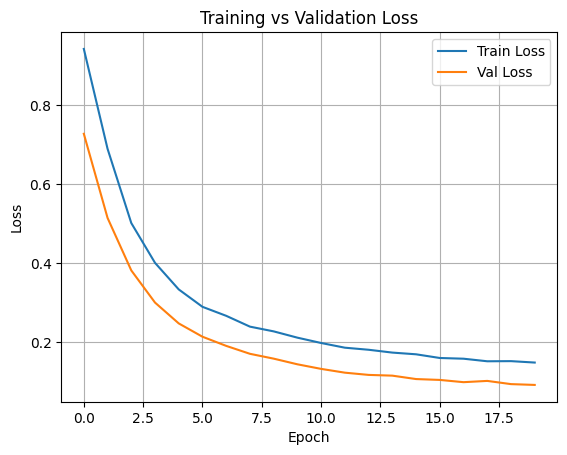

In [ ]:
model, history, mae, X_test, y_test, y_test_rescaled, y_scaler, meta_test, X_scaled_train, X_scaled_test= run_experiment(
    REACH_DIR, cutoff_ms=0, use_palm=True, n_fingers=5, n_phalanxes=5, use_masking=False, epochs=20, batch_size=16, seed=42)

plot_training_history(history)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_downsampled_predictions(model, sequence, total_timesteps, frame_times, max_frames=30):
    """
    Generates predictions for a sequence at downsampled time points.

    Args:
        model: The trained Keras model.
        sequence: The input sequence (already scaled and padded).
        total_timesteps: Total number of timesteps in the padded sequence.
        frame_times: List of actual frame times (in ms) for the original sequence.
        max_frames: The desired number of frames for downsampling.

    Returns:
        predictions: A list of predictions at the downsampled time points.
        times: A list of corresponding frame times (in ms).
    """
    # Pick 7 evenly spaced time steps from the original sequence length
    # instead of padded sequence length to align indices with frame_times
    indices = np.linspace(1, len(frame_times) - 1, max_frames)
    indices = np.round(indices).astype(int)
    indices = np.unique(np.clip(indices, 1, len(frame_times) - 1))


    predictions = []
    times = []
    print("indices:" , indices)
    for t in indices:
        partial = sequence[:t]
        padded = pad_sequences([partial.tolist()], maxlen=total_timesteps, padding='pre', dtype='float32')
        pred_scaled = model.predict(padded, verbose=0)[0]
        #print("for frame", t, ":", "partial:", partial, " padded:", padded)
        if t==256:
          print(type(partial))
          print(partial)
          print(padded)
          print("partial length:", len(partial))
          print("padded length:", len(padded))
          print("last arrays of padded:", padded[0][-5:])
          print(pred_scaled)
          predtest = y_scaler.inverse_transform([pred_scaled])[0]
          print(predtest)
          step2= padded
        if t==384:
          print(type(partial))
          print(partial)
          print(padded.shape)
          print("partial length:", len(partial))
          print("padded length:", len(padded))
          print("last arrays of padded:", padded[0][-5:])
          print(pred_scaled)
          predtest = y_scaler.inverse_transform([pred_scaled])[0]
          print(predtest)
          step3 = padded
          result_variable = (step2 == step3).all()

          if(result_variable == True):
            print("unfortunately we have a match")

        predictions.append(pred_scaled)
        times.append(frame_times[t - 1])  # Actual ms of input seen

    return predictions, times

### Naive Baseline

In [12]:
def evaluate_last_frame_baseline(X_scaled_test, y_test_rescaled, y_scaler, X_scaler):
    """
    Evaluates a baseline model that predicts the last frame of the input sequence.

    Args:
        X_scaled_test: The scaled test input sequences (list of arrays, not padded).
        y_test_rescaled: The rescaled ground truth target values for the test set.
        y_scaler: The scaler used to transform the target values.
        X_scaler: The scaler used to transform the input features.

    Returns:
        baseline_mae: The Mean Absolute Error of the baseline prediction.
    """
    baseline_predictions = []
    # Iterate through the unpadded test sequences
    for sequence in X_scaled_test:
        # Get the last frame of the scaled input sequence
        last_frame_scaled = sequence[-1]
        # The baseline prediction is simply this last frame
        baseline_predictions.append(last_frame_scaled)

    # Convert the list of predictions to a numpy array
    baseline_predictions_scaled = np.array(baseline_predictions, dtype='float32')

    # Rescale the baseline predictions back to original units (cm)
    baseline_predictions_rescaled = X_scaler.inverse_transform(baseline_predictions_scaled)

    # Important: The input features and target features have the same structure
    # in terms of the points included (fingertips, phalanxes, palm).
    # Therefore, we can compare the rescaled last input frame directly with the rescaled ground truth target.

    # Calculate the Mean Absolute Error
    baseline_mae = np.mean(np.abs(baseline_predictions_rescaled - y_test_rescaled))

    return baseline_mae

In [23]:
# Define the specific cutoff value to test
test_cutoff_ms = 200

print(f"\nRunning experiment for cutoff = {test_cutoff_ms} ms to compare with baseline")

# Run the experiment with the specified cutoff and configurations
# We capture all the returned values as we need X_scaled_test and y_test_rescaled for the baseline
model_350ms, history_350ms, mae_350ms, X_test_350ms, y_test_350ms, y_test_rescaled_350ms, y_scaler_350ms, meta_test_350ms, X_scaled_train_350ms, X_scaled_test_350ms, X_scaler_350ms = run_experiment(
    REACH_DIR,
    cutoff_ms=test_cutoff_ms,
    use_palm=False,
    n_fingers=1,
    n_phalanxes=0,
    use_masking=False,
    epochs=20,
    batch_size=16,
    seed=42
)

# Evaluate the last frame baseline using the test data from the 350ms experiment
baseline_mae_350ms = evaluate_last_frame_baseline(
    X_scaled_test_350ms,
    y_test_rescaled_350ms,
    y_scaler_350ms,
    X_scaler_350ms  # We need the X_scaler used during prepare_data
)

print(f"\n--- Comparison for {test_cutoff_ms} ms cutoff ---")
print(f"LSTM Model MAE: {mae_350ms:.4f} cm")
print(f"Last Frame Baseline MAE: {baseline_mae_350ms:.4f} cm")

# You can add a conditional statement to interpret the results
if mae_350ms < baseline_mae_350ms:
    print(f"The LSTM model performed {baseline_mae_350ms - mae_350ms:.4f} cm better than the last frame baseline.")
else:
    print(f"The last frame baseline performed {mae_350ms - baseline_mae_350ms:.4f} cm better than or equal to the LSTM model.")


Running experiment for cutoff = 200 ms to compare with baseline
(762, 938, 3)
length of longest sequence: 762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cutoff 200 ms — MAE: 0.6101 cm

--- Comparison for 200 ms cutoff ---
LSTM Model MAE: 0.6101 cm
Last Frame Baseline MAE: 1.2336 cm
The LSTM model performed 0.6235 cm better than the last frame baseline.


In [27]:
## Print coordinate results for a specific test sequence
print("\n--- Coordinate Comparison for a Sample Test Sequence ---")

# Choose an index for a test sequence (e.g., the first one)
sample_index = 4
print(f"Sample sequence file: {meta_test_350ms[sample_index]}")

# Get the scaled test input sequence (padded for the model)
sample_X_test_padded = X_test_350ms[sample_index:sample_index+1] # keep dimension for predict
# Get the unpadded scaled test input sequence for baseline
sample_X_scaled_test_unpadded = X_scaled_test_350ms[sample_index]
# Get the rescaled ground truth
sample_y_test_rescaled = y_test_rescaled_350ms[sample_index]

# Get the model's prediction for the sample sequence
sample_y_pred_scaled = model_350ms.predict(sample_X_test_padded, verbose=0)[0]
sample_y_pred_rescaled = y_scaler_350ms.inverse_transform([sample_y_pred_scaled])[0]

# Get the baseline prediction for the sample sequence
sample_baseline_prediction_scaled = sample_X_scaled_test_unpadded[-1]
sample_baseline_prediction_rescaled = X_scaler_350ms.inverse_transform([sample_baseline_prediction_scaled])[0]

# Print the coordinates
print("\nGround Truth Final Hand Coordinates (cm):")
print(sample_y_test_rescaled)

print("\nLSTM Model Prediction Final Hand Coordinates (cm):")
print(sample_y_pred_rescaled)

print("\nLast Frame Baseline Final Hand Coordinates (cm):")
print(sample_baseline_prediction_rescaled)

mae1=sample_y_test_rescaled-sample_y_pred_rescaled

mae2=sample_y_test_rescaled - sample_baseline_prediction_rescaled
print("--------")
print(mae1)
print(mae2)



--- Coordinate Comparison for a Sample Test Sequence ---
Sample sequence file: user4_R2G_object_Vulcano_trial1.txt

Ground Truth Final Hand Coordinates (cm):
[-9.395227  -1.9617425 -6.277718 ]

LSTM Model Prediction Final Hand Coordinates (cm):
[-9.08569428 -1.27580424 -6.48926747]

Last Frame Baseline Final Hand Coordinates (cm):
[-10.02893169  -1.23608258  -4.99314503]
--------
[-0.30953315 -0.68593828  0.2115494 ]
[ 0.63370426 -0.72565994 -1.28457303]


In [17]:

cutoff_values = list(range(0, 400, 50))
lstm_maes = []
baseline_maes = []

for cutoff_ms in cutoff_values:
    print(f"\n=== Cutoff: {cutoff_ms} ms ===")

    # Prepare data for this cutoff
    X, y, X_scaler, y_scaler, meta, X_scaled = prepare_data(
        REACH_DIR,
        cutoff_ms=cutoff_ms,
        use_palm=True,
        n_fingers=5,
        n_phalanxes=5
    )

    if len(X) < 10:
        print("Too few samples. Skipping.")
        lstm_maes.append(None)
        baseline_maes.append(None)
        continue

    # Consistent train/test split
    X_train, X_test, y_train, y_test, meta_train, meta_test, X_scaled_train, X_scaled_test = train_test_split(
        X, y, meta, X_scaled, test_size=0.2, random_state=42
    )

    # ---- Naive Baseline: predict last observed frame ----
    baseline_preds_scaled = [seq[-1] for seq in X_scaled_test]
    baseline_preds_scaled = np.array(baseline_preds_scaled, dtype='float32')
    baseline_preds_rescaled = X_scaler.inverse_transform(baseline_preds_scaled)
    y_test_rescaled = y_scaler.inverse_transform(y_test)
    baseline_mae = np.mean(np.abs(baseline_preds_rescaled - y_test_rescaled))
    baseline_maes.append(baseline_mae)

    # ---- LSTM Model ----
    X_train_padded = pad_sequences(X_train, padding='pre', dtype='float32')
    X_test_padded = pad_sequences(X_test, padding='pre', dtype='float32')
    y_train = np.array(y_train, dtype='float32')

    model = build_model(
        input_shape=X_train_padded.shape[1:],
        output_dim=y_train.shape[1],
        use_masking=False
    )

    model.fit(
        X_train_padded, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=16,
        verbose=0
    )

    y_pred = model.predict(X_test_padded)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    lstm_mae = np.mean(np.abs(y_pred_rescaled - y_test_rescaled))
    lstm_maes.append(lstm_mae)

    print(f"LSTM MAE: {lstm_mae:.4f} cm | Baseline MAE: {baseline_mae:.4f} cm")



=== Cutoff: 0 ms ===
(762, 1129, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM MAE: 0.2698 cm | Baseline MAE: 0.0000 cm

=== Cutoff: 50 ms ===
(762, 1081, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM MAE: 0.3240 cm | Baseline MAE: 0.3576 cm

=== Cutoff: 100 ms ===
(762, 1033, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LSTM MAE: 0.3870 cm | Baseline MAE: 0.6365 cm

=== Cutoff: 150 ms ===
(762, 984, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LSTM MAE: 0.4336 cm | Baseline MAE: 0.9049 cm

=== Cutoff: 200 ms ===
(762, 938, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM MAE: 0.4687 cm | Baseline MAE: 1.2003 cm

=== Cutoff: 250 ms ===
(762, 889, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM MAE: 0.5354 cm | Baseline MAE: 1.5448 cm

=== Cutoff: 300 ms ===
(762, 841, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM MAE: 0.5827 cm | Baseline MAE: 1.9266 cm

=== Cutoff: 350 ms ===
(762, 793, 33)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
LSTM MAE: 0.6040 cm | Baseline MAE: 2.3548 cm


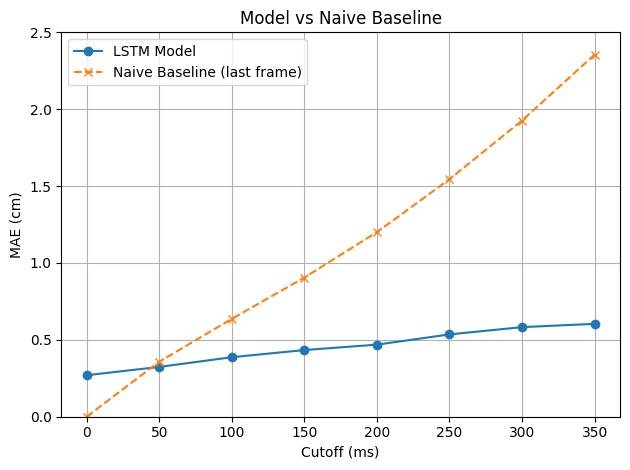

In [20]:
plt.plot(cutoff_values, lstm_maes, marker='o', label='LSTM Model')
plt.plot(cutoff_values, baseline_maes, marker='x', linestyle='--', label='Naive Baseline (last frame)')
plt.xlabel("Cutoff (ms)")
plt.ylabel("MAE (cm)")
plt.title("Model vs Naive Baseline")
plt.grid(True)
plt.ylim(0, 2.5)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:

cutoff_values = list(range(0, 400, 50))
lstm_maes_nopalm = []
baseline_maes_nopalm = []

for cutoff_ms in cutoff_values:
    print(f"\n=== Cutoff: {cutoff_ms} ms ===")

    # Prepare data for this cutoff
    X, y, X_scaler, y_scaler, meta, X_scaled = prepare_data(
        REACH_DIR,
        cutoff_ms=cutoff_ms,
        use_palm=False,
        n_fingers=5,
        n_phalanxes=5
    )

    if len(X) < 10:
        print("Too few samples. Skipping.")
        lstm_maes_nopalm.append(None)
        baseline_maes_nopalm.append(None)
        continue

    # Consistent train/test split
    X_train, X_test, y_train, y_test, meta_train, meta_test, X_scaled_train, X_scaled_test = train_test_split(
        X, y, meta, X_scaled, test_size=0.2, random_state=42
    )

    # ---- Naive Baseline: predict last observed frame ----
    baseline_preds_scaled = [seq[-1] for seq in X_scaled_test]
    baseline_preds_scaled = np.array(baseline_preds_scaled, dtype='float32')
    baseline_preds_rescaled = X_scaler.inverse_transform(baseline_preds_scaled)
    y_test_rescaled = y_scaler.inverse_transform(y_test)
    baseline_mae = np.mean(np.abs(baseline_preds_rescaled - y_test_rescaled))
    baseline_maes_nopalm.append(baseline_mae)

    # ---- LSTM Model ----
    X_train_padded = pad_sequences(X_train, padding='pre', dtype='float32')
    X_test_padded = pad_sequences(X_test, padding='pre', dtype='float32')
    y_train = np.array(y_train, dtype='float32')

    model = build_model(
        input_shape=X_train_padded.shape[1:],
        output_dim=y_train.shape[1],
        use_masking=False
    )

    model.fit(
        X_train_padded, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=16,
        verbose=0
    )

    y_pred = model.predict(X_test_padded)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    lstm_mae = np.mean(np.abs(y_pred_rescaled - y_test_rescaled))
    lstm_maes_nopalm.append(lstm_mae)

    print(f"LSTM MAE: {lstm_mae:.4f} cm | Baseline MAE: {baseline_mae:.4f} cm")



=== Cutoff: 0 ms ===
(762, 1129, 30)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LSTM MAE: 0.2352 cm | Baseline MAE: 0.0000 cm

=== Cutoff: 50 ms ===
(762, 1081, 30)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LSTM MAE: 0.2988 cm | Baseline MAE: 0.3193 cm

=== Cutoff: 100 ms ===
(762, 1033, 30)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LSTM MAE: 0.3460 cm | Baseline MAE: 0.5149 cm

=== Cutoff: 150 ms ===
(762, 984, 30)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM MAE: 0.4262 cm | Baseline MAE: 0.6608 cm

=== Cutoff: 200 ms ===
(762, 938, 30)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LSTM MAE: 0.4822 cm | Baseline MAE: 0.7995 cm

=== Cutoff: 250 ms ===
(762, 889, 30)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
LSTM MAE: 0.5432 cm | Baseline MAE: 0.9568 cm

=== Cutoff: 300 ms ===
(762, 841, 30)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM MAE: 0.5909 cm | Baseline MAE: 1.1252 cm

=== Cutoff: 350 ms ===
(762, 793, 30)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
LSTM MAE: 0.6269 cm | Baseline MAE: 1.3255 cm


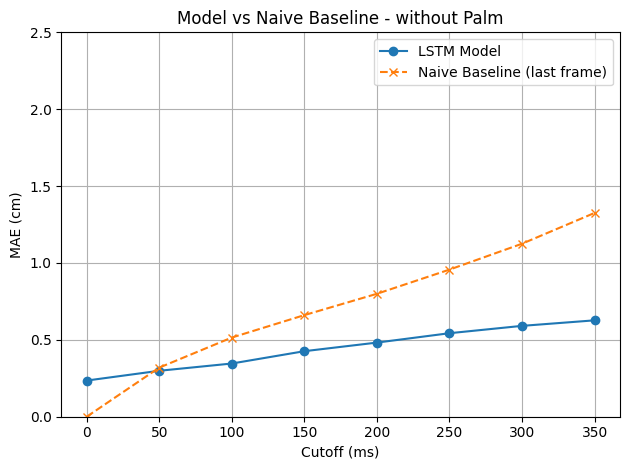

In [14]:
plt.plot(cutoff_values, lstm_maes_nopalm, marker='o', label='LSTM Model')
plt.plot(cutoff_values, baseline_maes_nopalm, marker='x', linestyle='--', label='Naive Baseline (last frame)')
plt.xlabel("Cutoff (ms)")
plt.ylabel("MAE (cm)")
plt.title("Model vs Naive Baseline - without Palm")
plt.grid(True)
plt.ylim(0, 2.5)
plt.legend()
plt.tight_layout()
plt.show()


### animation visualization zoomed out

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import numpy as np
import os

def save_hand_prediction_gif_matplotlib(predictions, ground_truth, scaler, times, original_sequence, filename="hand_prediction.gif", n_fingers=3, n_phalanxes=0, use_palm=True, elev=20, azim=-70, zoom_factor=1.5):
    """
    Saves a GIF of hand prediction evolution.
    Centralizes and zooms in on the predicted (red) and ground truth (green/blue) hand plots.
    """
    folder = "frames_temp"
    os.makedirs(folder, exist_ok=True)

    # Finger labels (adjust if you have more than 5 fingers)
    finger_labels = ["T", "I", "M", "R", "L"][:n_fingers]
    phalanx_labels = [f"P{i+1}" for i in range(n_phalanxes)]

    # Split ground truth into components
    gt_palm = ground_truth[-3:] if use_palm else np.zeros(3)
    gt_fingers = np.array(ground_truth[:3 * n_fingers]).reshape(n_fingers, 3) + gt_palm
    gt_phalanxes = np.array(ground_truth[3 * n_fingers:3 * (n_fingers + n_phalanxes)]).reshape(n_phalanxes, 3) + gt_palm if n_phalanxes > 0 else np.empty((0, 3))

    # Calculate axis limits: Include ground truth, predictions, and actual hand positions
    all_points = []
    all_points.extend(gt_fingers.flatten())
    all_points.extend(gt_phalanxes.flatten())
    all_points.extend(gt_palm)

    for pred_scaled in predictions:
        pred = scaler.inverse_transform([pred_scaled])[0]
        pred_palm = pred[-3:] if use_palm else np.zeros(3)
        pred_fingers = np.array(pred[:3 * n_fingers]).reshape(n_fingers, 3) + pred_palm
        pred_phalanxes = np.array(pred[3 * n_fingers:3 * (n_fingers + n_phalanxes)]).reshape(n_phalanxes, 3) + pred_palm if n_phalanxes > 0 else np.empty((0, 3))

        all_points.extend(pred_fingers.flatten())
        all_points.extend(pred_phalanxes.flatten())
        all_points.extend(pred_palm)

    for i in range(len(times)):
        current_time_index = times[i]
        closest_time_index = np.abs(np.array(original_sequence['FrameTime']) - current_time_index).argmin()
        actual_hand_data = original_sequence.iloc[closest_time_index]
        actual_palm = [actual_hand_data['M12x'], actual_hand_data['M12y'], actual_hand_data['M12z']] if use_palm else np.zeros(3)
        actual_fingers = [
            [actual_hand_data[f'M{j}x'] - actual_palm[0],
             actual_hand_data[f'M{j}y'] - actual_palm[1],
             actual_hand_data[f'M{j}z'] - actual_palm[2]] for j in range(1, n_fingers + 1)
        ]
        actual_fingers = np.array(actual_fingers)
        actual_phalanxes = [
            [actual_hand_data[f'M{j}x'] - actual_palm[0],
             actual_hand_data[f'M{j}y'] - actual_palm[1],
             actual_hand_data[f'M{j}z'] - actual_palm[2]] for j in range(6, 6 + n_phalanxes)
        ] if n_phalanxes > 0 else np.empty((0, 3))
        actual_phalanxes = np.array(actual_phalanxes)
        all_points.extend(actual_fingers.flatten())
        all_points.extend(actual_phalanxes.flatten())
        all_points.extend(actual_palm)

    all_points = np.array(all_points).reshape(-1, 3)

    # Calculate center point of all hand positions (ground truth and predictions)
    center_point = np.mean(all_points, axis=0)

    # Adjust axis limits to center and zoom in
    xlim_range = (np.max(all_points[:, 0]) - np.min(all_points[:, 0])) / zoom_factor
    ylim_range = (np.max(all_points[:, 1]) - np.min(all_points[:, 1])) / zoom_factor
    zlim_range = (np.max(all_points[:, 2]) - np.min(all_points[:, 2])) / zoom_factor

    xlim = (center_point[0] - xlim_range / 2, center_point[0] + xlim_range / 2)
    ylim = (center_point[1] - ylim_range / 2, center_point[1] + ylim_range / 2)
    zlim = (center_point[2] - zlim_range / 2, center_point[2] + zlim_range / 2)

    frame_paths = []

    # Create the initial plot with ground truth hand
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)  # Set view angle
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    # Ground truth lines (plotted only once) - Chained Skeleton - Without text labels
    if use_palm:
        for j in range(n_fingers):
            # Connect palm to first phalanx (or fingertip if no phalanxes)
            connect_to = gt_phalanxes[j] if n_phalanxes > 0 else gt_fingers[j]
            ax.plot([gt_palm[0], connect_to[0]],
                    [gt_palm[1], connect_to[1]],
                    [gt_palm[2], connect_to[2]],
                    'g-')

            # Connect phalanxes (if any) to fingertip
            if n_phalanxes > 0:
                ax.plot([gt_phalanxes[j, 0], gt_fingers[j, 0]],
                        [gt_phalanxes[j, 1], gt_fingers[j, 1]],
                        [gt_phalanxes[j, 2], gt_fingers[j, 2]],
                        'g-')

        ax.scatter(gt_palm[0], gt_palm[1], gt_palm[2], c='green')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Now loop through predictions and only update the prediction lines
    for i, pred_scaled in enumerate(predictions):
        pred = scaler.inverse_transform([pred_scaled])[0]
        pred_palm = pred[-3:] if use_palm else np.zeros(3)
        pred_fingers = np.array(pred[:3 * n_fingers]).reshape(n_fingers, 3) + pred_palm
        pred_phalanxes = np.array(pred[3 * n_fingers:3 * (n_fingers + n_phalanxes)]).reshape(n_phalanxes, 3) + pred_palm if n_phalanxes > 0 else np.empty((0, 3))


        # Remove previous prediction lines if they exist
        if i > 0:
            for line in pred_lines:
                line.remove()
            for text in pred_texts:
                text.remove()
            for line in actual_lines:  # Remove actual hand lines
                line.remove()
            for line in pred_phalanx_lines:  # Remove predicted phalanx lines
                line.remove()
            for text in pred_phalanx_texts:  # Remove predicted phalanx text
                text.remove()
            # Assuming actual_phalanx_lines and actual_phalanx_texts are not used anymore


        # Prediction lines (updated for each frame) - Chained Skeleton
        pred_lines = []
        pred_texts = []
        if use_palm:
            for j in range(n_fingers):
                # Connect palm to first phalanx (or fingertip if no phalanxes)
                connect_to = pred_phalanxes[j] if n_phalanxes > 0 else pred_fingers[j]
                line, = ax.plot([pred_palm[0], connect_to[0]],
                                [pred_palm[1], connect_to[1]],
                                [pred_palm[2], connect_to[2]],
                                'r--')
                pred_lines.append(line)

                # Connect phalanxes (if any) to fingertip
                if n_phalanxes > 0:
                    line, = ax.plot([pred_phalanxes[j, 0], pred_fingers[j, 0]],
                                    [pred_phalanxes[j, 1], pred_fingers[j, 1]],
                                    [pred_phalanxes[j, 2], pred_fingers[j, 2]],
                                    'r--')
                    pred_lines.append(line)

                text = ax.text(pred_fingers[j, 0], pred_fingers[j, 1], pred_fingers[j, 2], finger_labels[j], color='red')
                pred_texts.append(text)

            # Predicted phalanx lines (updated for each frame) - with labels
            pred_phalanx_lines = []
            pred_phalanx_texts = []
            for j in range(n_phalanxes):
                # Assuming phalanx labels are not needed anymore
                # text = ax.text(pred_phalanxes[j, 0], pred_phalanxes[j, 1], pred_phalanxes[j, 2], phalanx_labels[j], color='red')
                # pred_phalanx_texts.append(text)
                pass  # Placeholder if you need to add logic for phalanx labels later

            ax.scatter(pred_palm[0], pred_palm[1], pred_palm[2], c='red')

        ax.set_title(f"Step {i+1} | Input time: {times[i]:.1f} ms")

        # Get actual hand position at current time
        current_time_index = times[i]
        closest_time_index = np.abs(np.array(original_sequence['FrameTime']) - current_time_index).argmin()
        actual_hand_data = original_sequence.iloc[closest_time_index]

        # Reshape and get actual palm and finger coordinates
        actual_palm = [actual_hand_data['M12x'], actual_hand_data['M12y'], actual_hand_data['M12z']] if use_palm else np.zeros(3)
        actual_fingers = [
            [actual_hand_data[f'M{j}x'] - actual_palm[0],
             actual_hand_data[f'M{j}y'] - actual_palm[1],
             actual_hand_data[f'M{j}z'] - actual_palm[2]] for j in range(1, n_fingers + 1)
        ]
        actual_fingers = np.array(actual_fingers)
        # Assuming actual_phalanxes is not used anymore

        # Plot actual hand position (in blue) - Only palm, no text labels
        actual_lines = []  # Still needed to remove lines in the next frame
        if use_palm:
            for j in range(n_fingers):
                # Connect palm to first phalanx (or fingertip if no phalanxes)
                connect_to_actual = actual_phalanxes[j] if n_phalanxes > 0 and actual_phalanxes.size > 0 else actual_fingers[j]
                line, = ax.plot([actual_palm[0], connect_to_actual[0] + actual_palm[0]],
                                [actual_palm[1], connect_to_actual[1] + actual_palm[1]],
                                [actual_palm[2], connect_to_actual[2] + actual_palm[2]],
                                'b:')  # Blue dotted line
                actual_lines.append(line)

                # Connect phalanxes (if any) to fingertip
                if n_phalanxes > 0 and actual_phalanxes.size > 0:
                    line, = ax.plot([actual_phalanxes[j, 0] + actual_palm[0], actual_fingers[j, 0] + actual_palm[0]],
                                    [actual_phalanxes[j, 1] + actual_palm[1], actual_fingers[j, 1] + actual_palm[1]],
                                    [actual_phalanxes[j, 2] + actual_palm[2], actual_fingers[j, 2] + actual_palm[2]],
                                    'b:')  # Blue dotted line
                    actual_lines.append(line)

            ax.scatter(actual_palm[0], actual_palm[1], actual_palm[2], c='blue')

        frame_path = os.path.join(folder, f"frame_{i:03d}.png")
        plt.tight_layout()
        plt.savefig(frame_path)
        frame_paths.append(frame_path)

    # Assemble into GIF
    images = [imageio.v2.imread(fp) for fp in frame_paths]
    imageio.mimsave(filename, images, duration=500.0)
    print(f" GIF saved to: {filename} ({len(images)} frames)")

    # Clean up
    for fp in frame_paths:
        os.remove(fp)
    os.rmdir(folder)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import numpy as np
import os

def save_hand_prediction_gif_matplotlib(predictions, ground_truth, scaler, times, original_sequence, filename="hand_prediction.gif", n_fingers=3, n_phalanxes=0, use_palm=True, elev=20, azim=-70, zoom_factor=1.5):
    folder = "frames_temp"
    os.makedirs(folder, exist_ok=True)

    finger_labels = ["T", "I", "M", "R", "L"][:n_fingers]
    phalanx_labels = [f"P{i+1}" for i in range(n_phalanxes)]

    gt_palm = ground_truth[-3:] if use_palm else np.zeros(3)
    gt_fingers = np.array(ground_truth[:3 * n_fingers]).reshape(n_fingers, 3) + gt_palm
    gt_phalanxes = np.array(ground_truth[3 * n_fingers:3 * (n_fingers + n_phalanxes)]).reshape(n_phalanxes, 3) + gt_palm if n_phalanxes > 0 else np.empty((0, 3))

    # Collect only predicted and ground truth points for axis limits
    all_points = []
    all_points.extend(gt_fingers.flatten())
    all_points.extend(gt_phalanxes.flatten())
    all_points.extend(gt_palm)

    for pred_scaled in predictions:
        pred = scaler.inverse_transform([pred_scaled])[0]
        pred_palm = pred[-3:] if use_palm else np.zeros(3)
        pred_fingers = np.array(pred[:3 * n_fingers]).reshape(n_fingers, 3) + pred_palm
        pred_phalanxes = np.array(pred[3 * n_fingers:3 * (n_fingers + n_phalanxes)]).reshape(n_phalanxes, 3) + pred_palm if n_phalanxes > 0 else np.empty((0, 3))

        all_points.extend(pred_fingers.flatten())
        all_points.extend(pred_phalanxes.flatten())
        all_points.extend(pred_palm)

    all_points = np.array(all_points).reshape(-1, 3)
    center_point = np.mean(all_points, axis=0)

    xlim_range = (np.max(all_points[:, 0]) - np.min(all_points[:, 0])) / zoom_factor
    ylim_range = (np.max(all_points[:, 1]) - np.min(all_points[:, 1])) / zoom_factor
    zlim_range = (np.max(all_points[:, 2]) - np.min(all_points[:, 2])) / zoom_factor

    xlim = (center_point[0] - xlim_range / 2, center_point[0] + xlim_range / 2)
    ylim = (center_point[1] - ylim_range / 2, center_point[1] + ylim_range / 2)
    zlim = (center_point[2] - zlim_range / 2, center_point[2] + zlim_range / 2)

    frame_paths = []

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    if use_palm:
        for j in range(n_fingers):
            connect_to = gt_phalanxes[j] if n_phalanxes > 0 else gt_fingers[j]
            ax.plot([gt_palm[0], connect_to[0]],
                    [gt_palm[1], connect_to[1]],
                    [gt_palm[2], connect_to[2]],
                    'g-')

            if n_phalanxes > 0:
                ax.plot([gt_phalanxes[j, 0], gt_fingers[j, 0]],
                        [gt_phalanxes[j, 1], gt_fingers[j, 1]],
                        [gt_phalanxes[j, 2], gt_fingers[j, 2]],
                        'g-')

        ax.scatter(gt_palm[0], gt_palm[1], gt_palm[2], c='green')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    for i, pred_scaled in enumerate(predictions):
        pred = scaler.inverse_transform([pred_scaled])[0]
        pred_palm = pred[-3:] if use_palm else np.zeros(3)
        pred_fingers = np.array(pred[:3 * n_fingers]).reshape(n_fingers, 3) + pred_palm
        pred_phalanxes = np.array(pred[3 * n_fingers:3 * (n_fingers + n_phalanxes)]).reshape(n_phalanxes, 3) + pred_palm if n_phalanxes > 0 else np.empty((0, 3))

        if i > 0:
            for line in pred_lines:
                line.remove()
            for text in pred_texts:
                text.remove()
            for line in actual_lines:
                line.remove()
            for line in pred_phalanx_lines:
                line.remove()
            for text in pred_phalanx_texts:
                text.remove()

        pred_lines = []
        pred_texts = []
        if use_palm:
            for j in range(n_fingers):
                connect_to = pred_phalanxes[j] if n_phalanxes > 0 else pred_fingers[j]
                line, = ax.plot([pred_palm[0], connect_to[0]],
                                [pred_palm[1], connect_to[1]],
                                [pred_palm[2], connect_to[2]],
                                'r--')
                pred_lines.append(line)

                if n_phalanxes > 0:
                    line, = ax.plot([pred_phalanxes[j, 0], pred_fingers[j, 0]],
                                    [pred_phalanxes[j, 1], pred_fingers[j, 1]],
                                    [pred_phalanxes[j, 2], pred_fingers[j, 2]],
                                    'r--')
                    pred_lines.append(line)

                text = ax.text(pred_fingers[j, 0], pred_fingers[j, 1], pred_fingers[j, 2], finger_labels[j], color='red')
                pred_texts.append(text)

            pred_phalanx_lines = []
            pred_phalanx_texts = []
            for j in range(n_phalanxes):
                pass  # Placeholder for future labeling

            ax.scatter(pred_palm[0], pred_palm[1], pred_palm[2], c='red')

        ax.set_title(f"Step {i+1} | Input time: {times[i]:.1f} ms")

        current_time_index = times[i]
        closest_time_index = np.abs(np.array(original_sequence['FrameTime']) - current_time_index).argmin()
        actual_hand_data = original_sequence.iloc[closest_time_index]

        actual_palm = [actual_hand_data['M12x'], actual_hand_data['M12y'], actual_hand_data['M12z']] if use_palm else np.zeros(3)
        actual_fingers = [
            [actual_hand_data[f'M{j}x'] - actual_palm[0],
             actual_hand_data[f'M{j}y'] - actual_palm[1],
             actual_hand_data[f'M{j}z'] - actual_palm[2]] for j in range(1, n_fingers + 1)
        ]
        actual_fingers = np.array(actual_fingers)
        actual_phalanxes = [
            [actual_hand_data[f'M{j}x'] - actual_palm[0],
             actual_hand_data[f'M{j}y'] - actual_palm[1],
             actual_hand_data[f'M{j}z'] - actual_palm[2]] for j in range(6, 6 + n_phalanxes)
        ] if n_phalanxes > 0 else np.empty((0, 3))
        actual_phalanxes = np.array(actual_phalanxes)

        actual_lines = []
        if use_palm:
            for j in range(n_fingers):
                connect_to_actual = actual_phalanxes[j] if n_phalanxes > 0 and actual_phalanxes.size > 0 else actual_fingers[j]
                line, = ax.plot([actual_palm[0], connect_to_actual[0] + actual_palm[0]],
                                [actual_palm[1], connect_to_actual[1] + actual_palm[1]],
                                [actual_palm[2], connect_to_actual[2] + actual_palm[2]],
                                'b:')
                actual_lines.append(line)

                if n_phalanxes > 0 and actual_phalanxes.size > 0:
                    line, = ax.plot([actual_phalanxes[j, 0] + actual_palm[0], actual_fingers[j, 0] + actual_palm[0]],
                                    [actual_phalanxes[j, 1] + actual_palm[1], actual_fingers[j, 1] + actual_palm[1]],
                                    [actual_phalanxes[j, 2] + actual_palm[2], actual_fingers[j, 2] + actual_palm[2]],
                                    'b:')
                    actual_lines.append(line)

            ax.scatter(actual_palm[0], actual_palm[1], actual_palm[2], c='blue')

        frame_path = os.path.join(folder, f"frame_{i:03d}.png")
        plt.tight_layout()
        plt.savefig(frame_path)
        frame_paths.append(frame_path)

    images = [imageio.v2.imread(fp) for fp in frame_paths]
    imageio.mimsave(filename, images, duration=500.0)
    print(f" GIF saved to: {filename} ({len(images)} frames)")

    for fp in frame_paths:
        os.remove(fp)
    os.rmdir(folder)
    plt.show()


In [ ]:
i = 0  # Test sequence index
print(meta_test[i])
sequence = X_scaled_test[i] # non padded
print("last 5 unpadded frames:\n", sequence[-5:])
timesteps = X_scaled_test[i].shape[0]
ground_truth = y_test_rescaled[i]
frame_times = get_frame_times(os.path.join(REACH_DIR, meta_test[i]), cutoff_ms=0)
print(timesteps)

user16_R2G_object_Box_Medium_trial3.txt
last 5 unpadded frames:
 [[ 1.4722383  -0.87303257 -0.9848016  -0.18381715 -0.24391922 -0.38190228
   0.3740406  -0.45373306 -0.9352513   0.08540091 -2.2485414  -1.852731
  -0.15561777 -2.1087377  -1.445625    1.7474949  -0.66219103 -0.7445416
  -0.23379378 -0.6361974  -0.59167904  0.48131883 -0.27905348 -1.1168859
   0.03240205 -2.2207332  -2.741295    0.08567739 -1.4842895  -1.3173546
  -1.335513    1.1760831  -0.59385574]
 [ 1.4808176  -0.87096    -0.9882072  -0.18510006 -0.24388638 -0.3991961
   0.37504813 -0.459258   -0.94818336  0.08950309 -2.2482064  -1.8599061
  -0.15184149 -2.1102147  -1.446798    1.7528266  -0.6593035  -0.7523298
  -0.24068856 -0.6333702  -0.6084417   0.47871342 -0.28023136 -1.1303625
   0.03667277 -2.204929   -2.7514951   0.08830253 -1.4823343  -1.321874
  -1.3365759   1.1762335  -0.5959648 ]
 [ 1.4876817  -0.8735238  -0.98834103 -0.18610603 -0.25336033 -0.40412936
   0.37526554 -0.46853322 -0.96052456  0.09252045 -2.2

In [ ]:
original_sequence = pd.read_csv(os.path.join(REACH_DIR, meta_test[i]), names=header)

In [ ]:
print(len(X_scaled_test[i]))

767


In [ ]:
file_path = os.path.join(REACH_DIR, meta_test[i])
print(meta_test[i])
frame_times = get_frame_times(file_path, cutoff_ms=0)
print(frame_times)
print(len(frame_times))

user16_R2G_object_Box_Medium_trial3.txt
[0.0, 1.0639, 2.1081, 3.1694, 4.1466, 5.1741, 6.1851, 7.2631, 8.3103, 9.3937, 10.4019, 11.4397, 12.6134, 13.504, 14.4993, 15.6106, 16.703, 17.8251, 18.8044, 19.8163, 20.8667, 21.9387, 22.9637, 24.0253, 25.0655, 26.0563, 27.1606, 28.1064, 29.2136, 30.1551, 31.2443, 32.3037, 33.2764, 34.3854, 35.3918, 36.4097, 37.4119, 38.5473, 39.6103, 40.548, 41.7356, 42.7123, 43.782, 44.7834, 45.9089, 46.891, 47.9069, 48.9183, 50.03, 51.1037, 52.1515, 53.1505, 54.1848, 55.1542, 56.2124, 57.2558, 58.2797, 59.403, 60.4216, 61.4232, 62.4454, 63.5405, 64.5361, 65.5869, 66.7431, 67.7086, 68.7664, 69.8189, 70.9023, 71.8623, 72.897, 74.0197, 75.0889, 76.0266, 77.1696, 78.177, 79.1126, 80.1887, 81.2499, 82.2504, 83.2778, 84.3424, 85.4048, 86.4293, 87.4381, 88.5621, 89.5911, 90.5819, 91.6241, 92.7487, 93.7037, 94.7773, 95.8776, 96.9131, 98.0112, 99.0299, 100.0173, 101.0734, 102.1073, 103.1429, 104.165, 105.178, 106.2058, 107.2703, 108.283, 109.3349, 110.4906, 111.471, 11

In [ ]:
predictions, times = get_downsampled_predictions(model, sequence, timesteps, frame_times, max_frames=7)

indices: [  1 128 256 384 511 638 766]
<class 'numpy.ndarray'>
[[ 2.444089    1.6252352  -0.04150455 ...  1.6171528  -1.6631346
  -2.1009977 ]
 [ 2.4392805   1.6247333  -0.04134245 ...  1.6149623  -1.6622299
  -2.0932696 ]
 [ 2.4354622   1.6249158  -0.04094092 ...  1.6125991  -1.6614983
  -2.0857503 ]
 ...
 [ 0.65479666 -0.1275127   0.04314572 ...  0.31824294 -0.58360815
  -0.01500912]
 [ 0.65328044 -0.135523    0.04182113 ...  0.31219003 -0.5778227
  -0.01453475]
 [ 0.6513651  -0.14343397  0.04076942 ...  0.30624712 -0.57201993
  -0.01409704]]
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.65479666 -0.1275127   0.04314572 ...  0.31824294 -0.58360815
   -0.01500912]
  [ 0.65328044 -0.135523    0.04182113 ...  0.31219003 -0.5778227
   -0.01453475]
  [ 0.6513651  -0.14343397  0.04076942 ...  0.3062471

In [ ]:
print(predictions)

[array([ 2.08729178e-01,  2.97178119e-01,  1.32588111e-02,  3.60378414e-01,
        1.71591878e-01,  1.11125410e-04,  5.86449802e-01,  2.68483222e-01,
        1.14950538e-01,  5.72998464e-01,  6.32354543e-02,  1.23122230e-01,
        4.91570979e-01,  2.69080102e-02,  2.50990868e-01,  1.32515877e-01,
        3.92018259e-01,  3.75463627e-02,  1.17414728e-01,  1.14048280e-01,
       -2.39698946e-01,  4.85525638e-01,  9.77095813e-02,  5.68849072e-02,
        6.19971693e-01,  2.16313258e-01,  4.41218689e-02,  5.31571686e-01,
       -8.76233876e-02,  3.43742192e-01, -6.03404269e-02, -1.22697204e-01,
       -3.57941955e-01], dtype=float32), array([ 0.12709866,  0.20106933, -0.07646395, -0.07961789,  0.01599468,
       -0.09342349,  0.52244073,  0.05309276,  0.01764981,  0.51962954,
       -0.02887894,  0.15777293,  0.5814168 , -0.05269971,  0.1920741 ,
        0.13215028,  0.20040375, -0.12485334, -0.04593928, -0.07431636,
       -0.06105508,  0.6950506 ,  0.41539484,  0.18769982,  0.87967247

In [ ]:
!pip install -U kaleido

 GIF saved to: prediction_evolution_updated.gif (7 frames)


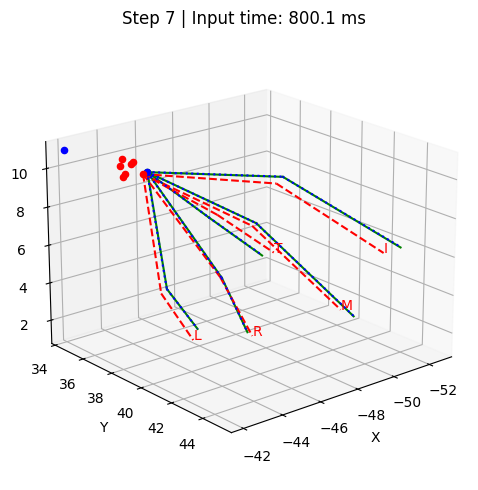

In [ ]:
%matplotlib inline
save_hand_prediction_gif_matplotlib(predictions, ground_truth, y_scaler, times, original_sequence=original_sequence, filename="prediction_evolution_updated.gif", n_fingers=5, n_phalanxes=5, use_palm=True, elev=20, azim=50, zoom_factor=0.9)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_ground_truth_3d(ground_truth, n_fingers=3, n_phalanxes=0, use_palm=True, elev=20, azim=-70):
    """Plots the ground truth hand position in 3D with points on fingertips and phalanxes."""

    # Finger labels
    finger_labels = ["T", "I", "M", "R", "L"][:n_fingers]
    phalanx_labels = [f"P{i+1}" for i in range(n_phalanxes)]

    # Split ground truth into components
    gt_palm = ground_truth[-3:] if use_palm else np.zeros(3)
    gt_fingers = np.array(ground_truth[:3 * n_fingers]).reshape(n_fingers, 3) + gt_palm
    gt_phalanxes = np.array(ground_truth[3 * n_fingers:3 * (n_fingers + n_phalanxes)]).reshape(n_phalanxes, 3) + gt_palm if n_phalanxes > 0 else np.empty((0, 3))

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)

    # Plot ground truth hand
    if use_palm:
        for j in range(n_fingers):
            # Connect palm to first phalanx (or fingertip if no phalanxes)
            connect_to = gt_phalanxes[j] if n_phalanxes > 0 else gt_fingers[j]
            ax.plot([gt_palm[0], connect_to[0]],
                    [gt_palm[1], connect_to[1]],
                    [gt_palm[2], connect_to[2]],
                    'g-')

            # Connect phalanxes (if any) to fingertip
            if n_phalanxes > 0:
                ax.plot([gt_phalanxes[j, 0], gt_fingers[j, 0]],
                        [gt_phalanxes[j, 1], gt_fingers[j, 1]],
                        [gt_phalanxes[j, 2], gt_fingers[j, 2]],
                        'g-')

            ax.text(gt_fingers[j, 0], gt_fingers[j, 1], gt_fingers[j, 2], finger_labels[j], color='green')

        # Plot fingertips as points
        for j in range(n_fingers):
            ax.scatter(gt_fingers[j, 0], gt_fingers[j, 1], gt_fingers[j, 2], c='red', marker='o', label='Fingertip' if j == 0 else "")

        # Plot phalanxes as points (if present)
        for j in range(n_phalanxes):
            ax.scatter(gt_phalanxes[j, 0], gt_phalanxes[j, 1], gt_phalanxes[j, 2], c='blue', marker='o', label='Phalanx' if j == 0 else "")

        ax.scatter(gt_palm[0], gt_palm[1], gt_palm[2], c='green', marker='o', label='Palm')
        ax.text(gt_palm[0], gt_palm[1], gt_palm[2], 'Palm', color='green')

    # Set plot labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Ground Truth Hand Position")
    ax.legend()  # Show legend for point labels (fingertip, phalanx, palm)

    plt.show()

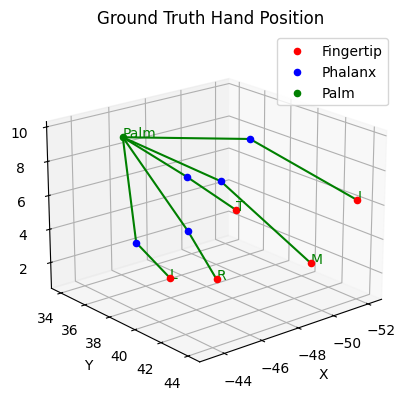

In [ ]:
%matplotlib inline
# Assuming you have y_test_rescaled[0] as your ground truth data
plot_ground_truth_3d(y_test_rescaled[0], n_fingers=5, n_phalanxes=5, use_palm=True,elev=20, azim=50)